# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from skimage import io
import torch.nn.functional as f

# Load dataset

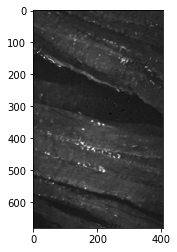

In [2]:
# loading dataset
data_dir = '/home/jessew/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
filenames = os.listdir(data_dir)
# print(filenames)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    plt.imshow(img[:,:,5], cmap='gray')
#     plt.show()
    img_stack.append(img)

In [3]:
# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')
print(img_stack.shape)

(25, 681, 406, 9)


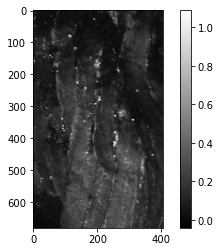

In [4]:
# choose a slice and show
plt.imshow(img_stack[2,:,:,5], cmap = 'gray')
plt.colorbar()
plt.show()

In [5]:
# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

img width = 681, img height = 406, img channels = 9


# Define model

In [7]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 3, kernel_size=1, stride=1),
            Sigmoid(),
            Softmax(dim=1)
        )
        
        """The spectral autoencoder has a bottleneck in the number of channels instead of upsampling and downsampling layers"""
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, nch, kernel_size=1, stride=1),            
            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.cnn_spectral_layers(x)
        return x
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        y = self.cnn_spectral_layers(z)
        return y

In [8]:
# instantiate the model by calling the function
model = Net()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
    (10): Softmax(dim=1)
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [9]:
# define loss function
criterion = nn.L1Loss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# set the model training device
"""cuda:0 for GPU 0, cuda:1 for GPU1, cpu for CPU"""
device = 'cuda:1'
print(device)
model.to(device) # load the model in the training device

cuda:1


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
    (10): Softmax(dim=1)
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [11]:
# prepare the input data before training
img_stack = torch.tensor(img_stack)
print(img_stack.shape)
img_stack = img_stack.to(device)

torch.Size([25, 681, 406, 9])


In [12]:
# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    return img

# Experiment with variance ordering loss

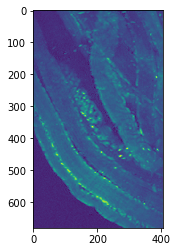

tensor(0.0004, device='cuda:0')

In [30]:
img=img_stack[1,:,:,3].detach().cpu().numpy()
plt.imshow(img)
plt.show()

meansq(img_stack[1,:,:,0])

In [13]:
def meansq(x):
    return torch.mean(x**2)

# Train model

  0%|          | 1/200 [00:03<10:02,  3.03s/it]

Epoch: 1 	Training Loss: 0.081634


  1%|          | 2/200 [00:03<04:41,  1.42s/it]

Epoch: 2 	Training Loss: 0.064608


  2%|▏         | 3/200 [00:03<02:58,  1.10it/s]

Epoch: 3 	Training Loss: 0.059833


  2%|▏         | 4/200 [00:03<02:10,  1.50it/s]

Epoch: 4 	Training Loss: 0.053422


  2%|▎         | 5/200 [00:04<01:44,  1.87it/s]

Epoch: 5 	Training Loss: 0.043221


  3%|▎         | 6/200 [00:04<01:28,  2.20it/s]

Epoch: 6 	Training Loss: 0.039093


  4%|▎         | 7/200 [00:04<01:17,  2.48it/s]

Epoch: 7 	Training Loss: 0.031139


  4%|▍         | 8/200 [00:05<01:10,  2.71it/s]

Epoch: 8 	Training Loss: 0.028234


  4%|▍         | 9/200 [00:05<01:06,  2.88it/s]

Epoch: 9 	Training Loss: 0.024826


  5%|▌         | 10/200 [00:05<01:03,  3.01it/s]

Epoch: 10 	Training Loss: 0.022951


  6%|▌         | 11/200 [00:06<01:00,  3.11it/s]

Epoch: 11 	Training Loss: 0.021798


  6%|▌         | 12/200 [00:06<00:59,  3.18it/s]

Epoch: 12 	Training Loss: 0.020128


  6%|▋         | 13/200 [00:06<00:57,  3.23it/s]

Epoch: 13 	Training Loss: 0.019922


  7%|▋         | 14/200 [00:06<00:56,  3.26it/s]

Epoch: 14 	Training Loss: 0.018606


  8%|▊         | 15/200 [00:07<00:56,  3.29it/s]

Epoch: 15 	Training Loss: 0.018467


  8%|▊         | 16/200 [00:07<00:55,  3.31it/s]

Epoch: 16 	Training Loss: 0.017858


  8%|▊         | 17/200 [00:07<00:55,  3.32it/s]

Epoch: 17 	Training Loss: 0.017505


  9%|▉         | 18/200 [00:08<00:54,  3.33it/s]

Epoch: 18 	Training Loss: 0.017067


 10%|▉         | 19/200 [00:08<00:54,  3.34it/s]

Epoch: 19 	Training Loss: 0.016453


 10%|█         | 20/200 [00:08<00:53,  3.34it/s]

Epoch: 20 	Training Loss: 0.016622


 10%|█         | 21/200 [00:08<00:53,  3.34it/s]

Epoch: 21 	Training Loss: 0.016895


 11%|█         | 22/200 [00:09<00:53,  3.35it/s]

Epoch: 22 	Training Loss: 0.015880


 12%|█▏        | 23/200 [00:09<00:52,  3.35it/s]

Epoch: 23 	Training Loss: 0.015891


 12%|█▏        | 24/200 [00:09<00:52,  3.35it/s]

Epoch: 24 	Training Loss: 0.015799


 12%|█▎        | 25/200 [00:10<00:52,  3.35it/s]

Epoch: 25 	Training Loss: 0.015722


 13%|█▎        | 26/200 [00:10<00:51,  3.35it/s]

Epoch: 26 	Training Loss: 0.015593


 14%|█▎        | 27/200 [00:10<00:51,  3.35it/s]

Epoch: 27 	Training Loss: 0.015305


 14%|█▍        | 28/200 [00:11<00:51,  3.35it/s]

Epoch: 28 	Training Loss: 0.015304


 14%|█▍        | 29/200 [00:11<00:51,  3.35it/s]

Epoch: 29 	Training Loss: 0.015105


 15%|█▌        | 30/200 [00:11<00:50,  3.35it/s]

Epoch: 30 	Training Loss: 0.015329


 16%|█▌        | 31/200 [00:11<00:50,  3.35it/s]

Epoch: 31 	Training Loss: 0.015194


 16%|█▌        | 32/200 [00:12<00:50,  3.35it/s]

Epoch: 32 	Training Loss: 0.015072


 16%|█▋        | 33/200 [00:12<00:49,  3.35it/s]

Epoch: 33 	Training Loss: 0.014898


 17%|█▋        | 34/200 [00:12<00:49,  3.35it/s]

Epoch: 34 	Training Loss: 0.014522


 18%|█▊        | 35/200 [00:13<00:49,  3.35it/s]

Epoch: 35 	Training Loss: 0.015121


 18%|█▊        | 36/200 [00:13<00:48,  3.35it/s]

Epoch: 36 	Training Loss: 0.014853


 18%|█▊        | 37/200 [00:13<00:48,  3.35it/s]

Epoch: 37 	Training Loss: 0.014900


 19%|█▉        | 38/200 [00:14<00:48,  3.35it/s]

Epoch: 38 	Training Loss: 0.014675


 20%|█▉        | 39/200 [00:14<00:48,  3.35it/s]

Epoch: 39 	Training Loss: 0.014681


 20%|██        | 40/200 [00:14<00:47,  3.35it/s]

Epoch: 40 	Training Loss: 0.014561


 20%|██        | 41/200 [00:14<00:47,  3.35it/s]

Epoch: 41 	Training Loss: 0.014220


 21%|██        | 42/200 [00:15<00:47,  3.35it/s]

Epoch: 42 	Training Loss: 0.014603


 22%|██▏       | 43/200 [00:15<00:46,  3.35it/s]

Epoch: 43 	Training Loss: 0.014682


 22%|██▏       | 44/200 [00:15<00:46,  3.35it/s]

Epoch: 44 	Training Loss: 0.014696


 22%|██▎       | 45/200 [00:16<00:46,  3.35it/s]

Epoch: 45 	Training Loss: 0.014453


 23%|██▎       | 46/200 [00:16<00:46,  3.34it/s]

Epoch: 46 	Training Loss: 0.014126


 24%|██▎       | 47/200 [00:16<00:45,  3.34it/s]

Epoch: 47 	Training Loss: 0.014509


 24%|██▍       | 48/200 [00:17<00:45,  3.34it/s]

Epoch: 48 	Training Loss: 0.014356


 24%|██▍       | 49/200 [00:17<00:45,  3.34it/s]

Epoch: 49 	Training Loss: 0.014069
Epoch: 50 	Training Loss: 0.014629


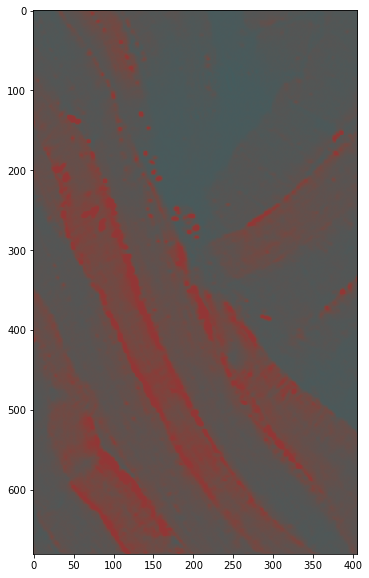

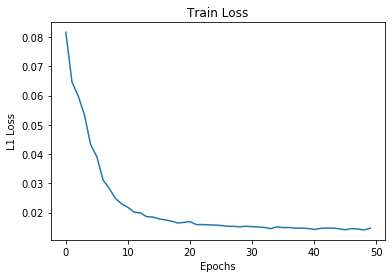

 26%|██▌       | 51/200 [00:18<00:52,  2.85it/s]

Epoch: 51 	Training Loss: 0.014382


 26%|██▌       | 52/200 [00:18<00:49,  2.98it/s]

Epoch: 52 	Training Loss: 0.013940


 26%|██▋       | 53/200 [00:18<00:47,  3.08it/s]

Epoch: 53 	Training Loss: 0.014423


 27%|██▋       | 54/200 [00:19<00:46,  3.15it/s]

Epoch: 54 	Training Loss: 0.014315


 28%|██▊       | 55/200 [00:19<00:45,  3.21it/s]

Epoch: 55 	Training Loss: 0.013876


 28%|██▊       | 56/200 [00:19<00:44,  3.25it/s]

Epoch: 56 	Training Loss: 0.014215


 28%|██▊       | 57/200 [00:19<00:43,  3.27it/s]

Epoch: 57 	Training Loss: 0.014232


 29%|██▉       | 58/200 [00:20<00:43,  3.29it/s]

Epoch: 58 	Training Loss: 0.014288


 30%|██▉       | 59/200 [00:20<00:42,  3.31it/s]

Epoch: 59 	Training Loss: 0.014161


 30%|███       | 60/200 [00:20<00:42,  3.32it/s]

Epoch: 60 	Training Loss: 0.013832


 30%|███       | 61/200 [00:21<00:41,  3.32it/s]

Epoch: 61 	Training Loss: 0.013784


 31%|███       | 62/200 [00:21<00:41,  3.33it/s]

Epoch: 62 	Training Loss: 0.014106


 32%|███▏      | 63/200 [00:21<00:41,  3.33it/s]

Epoch: 63 	Training Loss: 0.014230


 32%|███▏      | 64/200 [00:22<00:40,  3.33it/s]

Epoch: 64 	Training Loss: 0.013806


 32%|███▎      | 65/200 [00:22<00:40,  3.33it/s]

Epoch: 65 	Training Loss: 0.014189


 33%|███▎      | 66/200 [00:22<00:40,  3.34it/s]

Epoch: 66 	Training Loss: 0.014113


 34%|███▎      | 67/200 [00:22<00:39,  3.34it/s]

Epoch: 67 	Training Loss: 0.013733


 34%|███▍      | 68/200 [00:23<00:39,  3.34it/s]

Epoch: 68 	Training Loss: 0.013684


 34%|███▍      | 69/200 [00:23<00:39,  3.34it/s]

Epoch: 69 	Training Loss: 0.013682


 35%|███▌      | 70/200 [00:23<00:38,  3.34it/s]

Epoch: 70 	Training Loss: 0.014275


 36%|███▌      | 71/200 [00:24<00:38,  3.34it/s]

Epoch: 71 	Training Loss: 0.014160


 36%|███▌      | 72/200 [00:24<00:38,  3.34it/s]

Epoch: 72 	Training Loss: 0.013726


 36%|███▋      | 73/200 [00:24<00:38,  3.34it/s]

Epoch: 73 	Training Loss: 0.013628


 37%|███▋      | 74/200 [00:25<00:37,  3.34it/s]

Epoch: 74 	Training Loss: 0.014033


 38%|███▊      | 75/200 [00:25<00:37,  3.34it/s]

Epoch: 75 	Training Loss: 0.014105


 38%|███▊      | 76/200 [00:25<00:37,  3.34it/s]

Epoch: 76 	Training Loss: 0.013593


 38%|███▊      | 77/200 [00:25<00:36,  3.34it/s]

Epoch: 77 	Training Loss: 0.013979


 39%|███▉      | 78/200 [00:26<00:36,  3.34it/s]

Epoch: 78 	Training Loss: 0.013996


 40%|███▉      | 79/200 [00:26<00:36,  3.34it/s]

Epoch: 79 	Training Loss: 0.013535


 40%|████      | 80/200 [00:26<00:35,  3.34it/s]

Epoch: 80 	Training Loss: 0.013487


 40%|████      | 81/200 [00:27<00:35,  3.34it/s]

Epoch: 81 	Training Loss: 0.013467


 41%|████      | 82/200 [00:27<00:35,  3.34it/s]

Epoch: 82 	Training Loss: 0.014189


 42%|████▏     | 83/200 [00:27<00:35,  3.34it/s]

Epoch: 83 	Training Loss: 0.013963


 42%|████▏     | 84/200 [00:28<00:34,  3.34it/s]

Epoch: 84 	Training Loss: 0.013573


 42%|████▎     | 85/200 [00:28<00:34,  3.34it/s]

Epoch: 85 	Training Loss: 0.013811


 43%|████▎     | 86/200 [00:28<00:34,  3.34it/s]

Epoch: 86 	Training Loss: 0.013937


 44%|████▎     | 87/200 [00:28<00:33,  3.34it/s]

Epoch: 87 	Training Loss: 0.013588


 44%|████▍     | 88/200 [00:29<00:33,  3.34it/s]

Epoch: 88 	Training Loss: 0.013473


 44%|████▍     | 89/200 [00:29<00:33,  3.34it/s]

Epoch: 89 	Training Loss: 0.013705


 45%|████▌     | 90/200 [00:29<00:32,  3.34it/s]

Epoch: 90 	Training Loss: 0.013821


 46%|████▌     | 91/200 [00:30<00:32,  3.34it/s]

Epoch: 91 	Training Loss: 0.013514


 46%|████▌     | 92/200 [00:30<00:32,  3.34it/s]

Epoch: 92 	Training Loss: 0.013387


 46%|████▋     | 93/200 [00:30<00:32,  3.34it/s]

Epoch: 93 	Training Loss: 0.013292


 47%|████▋     | 94/200 [00:31<00:31,  3.34it/s]

Epoch: 94 	Training Loss: 0.013497


 48%|████▊     | 95/200 [00:31<00:31,  3.34it/s]

Epoch: 95 	Training Loss: 0.013457


 48%|████▊     | 96/200 [00:31<00:31,  3.34it/s]

Epoch: 96 	Training Loss: 0.013256


 48%|████▊     | 97/200 [00:31<00:30,  3.34it/s]

Epoch: 97 	Training Loss: 0.013151


 49%|████▉     | 98/200 [00:32<00:30,  3.34it/s]

Epoch: 98 	Training Loss: 0.012931


 50%|████▉     | 99/200 [00:32<00:30,  3.34it/s]

Epoch: 99 	Training Loss: 0.013248
Epoch: 100 	Training Loss: 0.014162


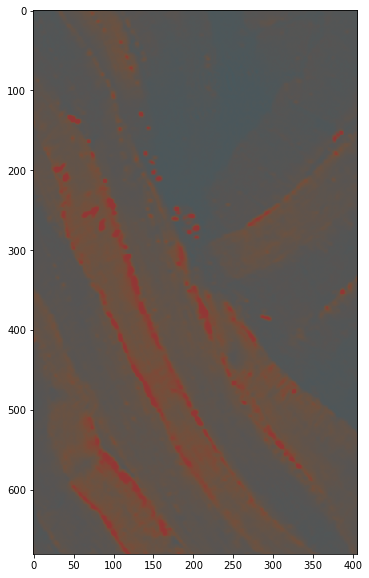

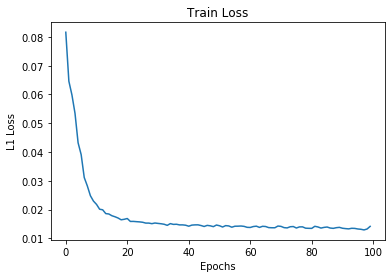

 50%|█████     | 101/200 [00:33<00:34,  2.86it/s]

Epoch: 101 	Training Loss: 0.013421


 51%|█████     | 102/200 [00:33<00:32,  2.99it/s]

Epoch: 102 	Training Loss: 0.013289


 52%|█████▏    | 103/200 [00:34<00:31,  3.09it/s]

Epoch: 103 	Training Loss: 0.013082


 52%|█████▏    | 104/200 [00:34<00:30,  3.16it/s]

Epoch: 104 	Training Loss: 0.012929


 52%|█████▎    | 105/200 [00:34<00:29,  3.21it/s]

Epoch: 105 	Training Loss: 0.012656


 53%|█████▎    | 106/200 [00:34<00:28,  3.25it/s]

Epoch: 106 	Training Loss: 0.014005


 54%|█████▎    | 107/200 [00:35<00:28,  3.27it/s]

Epoch: 107 	Training Loss: 0.013596


 54%|█████▍    | 108/200 [00:35<00:27,  3.29it/s]

Epoch: 108 	Training Loss: 0.013282


 55%|█████▍    | 109/200 [00:35<00:27,  3.31it/s]

Epoch: 109 	Training Loss: 0.012857


 55%|█████▌    | 110/200 [00:36<00:27,  3.32it/s]

Epoch: 110 	Training Loss: 0.012857


 56%|█████▌    | 111/200 [00:36<00:26,  3.32it/s]

Epoch: 111 	Training Loss: 0.012197


 56%|█████▌    | 112/200 [00:36<00:26,  3.33it/s]

Epoch: 112 	Training Loss: 0.012073


 56%|█████▋    | 113/200 [00:37<00:26,  3.33it/s]

Epoch: 113 	Training Loss: 0.012628


 57%|█████▋    | 114/200 [00:37<00:25,  3.33it/s]

Epoch: 114 	Training Loss: 0.012375


 57%|█████▊    | 115/200 [00:37<00:25,  3.33it/s]

Epoch: 115 	Training Loss: 0.011776


 58%|█████▊    | 116/200 [00:37<00:25,  3.33it/s]

Epoch: 116 	Training Loss: 0.012526


 58%|█████▊    | 117/200 [00:38<00:24,  3.34it/s]

Epoch: 117 	Training Loss: 0.011851


 59%|█████▉    | 118/200 [00:38<00:24,  3.34it/s]

Epoch: 118 	Training Loss: 0.011378


 60%|█████▉    | 119/200 [00:38<00:24,  3.34it/s]

Epoch: 119 	Training Loss: 0.013029


 60%|██████    | 120/200 [00:39<00:23,  3.34it/s]

Epoch: 120 	Training Loss: 0.011270


 60%|██████    | 121/200 [00:39<00:23,  3.34it/s]

Epoch: 121 	Training Loss: 0.010692


 61%|██████    | 122/200 [00:39<00:23,  3.34it/s]

Epoch: 122 	Training Loss: 0.011805


 62%|██████▏   | 123/200 [00:40<00:23,  3.34it/s]

Epoch: 123 	Training Loss: 0.011064


 62%|██████▏   | 124/200 [00:40<00:22,  3.34it/s]

Epoch: 124 	Training Loss: 0.010174


 62%|██████▎   | 125/200 [00:40<00:22,  3.34it/s]

Epoch: 125 	Training Loss: 0.010942


 63%|██████▎   | 126/200 [00:40<00:22,  3.34it/s]

Epoch: 126 	Training Loss: 0.010391


 64%|██████▎   | 127/200 [00:41<00:21,  3.34it/s]

Epoch: 127 	Training Loss: 0.010049


 64%|██████▍   | 128/200 [00:41<00:21,  3.33it/s]

Epoch: 128 	Training Loss: 0.009600


 64%|██████▍   | 129/200 [00:41<00:21,  3.34it/s]

Epoch: 129 	Training Loss: 0.010721


 65%|██████▌   | 130/200 [00:42<00:20,  3.34it/s]

Epoch: 130 	Training Loss: 0.010978


 66%|██████▌   | 131/200 [00:42<00:20,  3.34it/s]

Epoch: 131 	Training Loss: 0.009816


 66%|██████▌   | 132/200 [00:42<00:20,  3.34it/s]

Epoch: 132 	Training Loss: 0.009300


 66%|██████▋   | 133/200 [00:43<00:20,  3.34it/s]

Epoch: 133 	Training Loss: 0.010116


 67%|██████▋   | 134/200 [00:43<00:19,  3.33it/s]

Epoch: 134 	Training Loss: 0.008966


 68%|██████▊   | 135/200 [00:43<00:19,  3.33it/s]

Epoch: 135 	Training Loss: 0.009967


 68%|██████▊   | 136/200 [00:43<00:19,  3.33it/s]

Epoch: 136 	Training Loss: 0.008856


 68%|██████▊   | 137/200 [00:44<00:18,  3.33it/s]

Epoch: 137 	Training Loss: 0.008647


 69%|██████▉   | 138/200 [00:44<00:18,  3.33it/s]

Epoch: 138 	Training Loss: 0.009739


 70%|██████▉   | 139/200 [00:44<00:18,  3.33it/s]

Epoch: 139 	Training Loss: 0.008737


 70%|███████   | 140/200 [00:45<00:18,  3.33it/s]

Epoch: 140 	Training Loss: 0.008347


 70%|███████   | 141/200 [00:45<00:17,  3.33it/s]

Epoch: 141 	Training Loss: 0.008187


 71%|███████   | 142/200 [00:45<00:17,  3.33it/s]

Epoch: 142 	Training Loss: 0.009279


 72%|███████▏  | 143/200 [00:46<00:17,  3.33it/s]

Epoch: 143 	Training Loss: 0.008500


 72%|███████▏  | 144/200 [00:46<00:16,  3.33it/s]

Epoch: 144 	Training Loss: 0.008452


 72%|███████▎  | 145/200 [00:46<00:16,  3.33it/s]

Epoch: 145 	Training Loss: 0.009705


 73%|███████▎  | 146/200 [00:46<00:16,  3.33it/s]

Epoch: 146 	Training Loss: 0.008648


 74%|███████▎  | 147/200 [00:47<00:15,  3.33it/s]

Epoch: 147 	Training Loss: 0.008314


 74%|███████▍  | 148/200 [00:47<00:15,  3.33it/s]

Epoch: 148 	Training Loss: 0.008097


 74%|███████▍  | 149/200 [00:47<00:15,  3.33it/s]

Epoch: 149 	Training Loss: 0.009176
Epoch: 150 	Training Loss: 0.008275


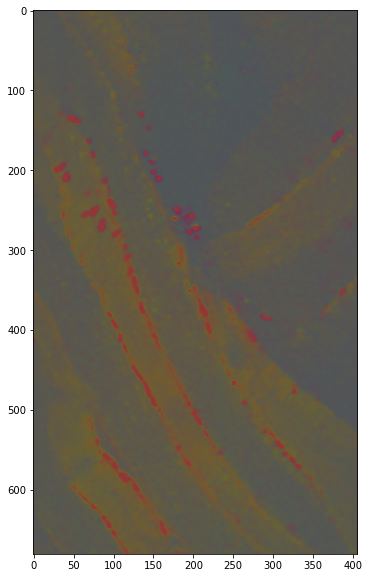

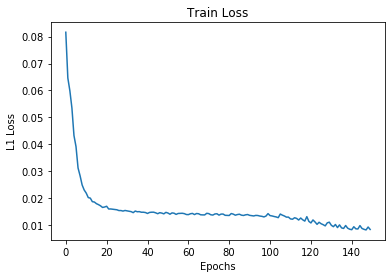

 76%|███████▌  | 151/200 [00:48<00:17,  2.81it/s]

Epoch: 151 	Training Loss: 0.007947


 76%|███████▌  | 152/200 [00:48<00:16,  2.95it/s]

Epoch: 152 	Training Loss: 0.008828


 76%|███████▋  | 153/200 [00:49<00:15,  3.06it/s]

Epoch: 153 	Training Loss: 0.008331


 77%|███████▋  | 154/200 [00:49<00:14,  3.13it/s]

Epoch: 154 	Training Loss: 0.008526


 78%|███████▊  | 155/200 [00:49<00:14,  3.19it/s]

Epoch: 155 	Training Loss: 0.008776


 78%|███████▊  | 156/200 [00:50<00:13,  3.23it/s]

Epoch: 156 	Training Loss: 0.008536


 78%|███████▊  | 157/200 [00:50<00:13,  3.26it/s]

Epoch: 157 	Training Loss: 0.008365


 79%|███████▉  | 158/200 [00:50<00:12,  3.28it/s]

Epoch: 158 	Training Loss: 0.009222


 80%|███████▉  | 159/200 [00:51<00:12,  3.30it/s]

Epoch: 159 	Training Loss: 0.008114


 80%|████████  | 160/200 [00:51<00:12,  3.31it/s]

Epoch: 160 	Training Loss: 0.007862


 80%|████████  | 161/200 [00:51<00:11,  3.31it/s]

Epoch: 161 	Training Loss: 0.008900


 81%|████████  | 162/200 [00:51<00:11,  3.32it/s]

Epoch: 162 	Training Loss: 0.008451


 82%|████████▏ | 163/200 [00:52<00:11,  3.32it/s]

Epoch: 163 	Training Loss: 0.008211


 82%|████████▏ | 164/200 [00:52<00:10,  3.32it/s]

Epoch: 164 	Training Loss: 0.008054


 82%|████████▎ | 165/200 [00:52<00:10,  3.33it/s]

Epoch: 165 	Training Loss: 0.008781


 83%|████████▎ | 166/200 [00:53<00:10,  3.33it/s]

Epoch: 166 	Training Loss: 0.008344


 84%|████████▎ | 167/200 [00:53<00:09,  3.33it/s]

Epoch: 167 	Training Loss: 0.007986


 84%|████████▍ | 168/200 [00:53<00:09,  3.33it/s]

Epoch: 168 	Training Loss: 0.008568


 84%|████████▍ | 169/200 [00:54<00:09,  3.33it/s]

Epoch: 169 	Training Loss: 0.008582


 85%|████████▌ | 170/200 [00:54<00:09,  3.33it/s]

Epoch: 170 	Training Loss: 0.008556


 86%|████████▌ | 171/200 [00:54<00:08,  3.33it/s]

Epoch: 171 	Training Loss: 0.008261


 86%|████████▌ | 172/200 [00:54<00:08,  3.33it/s]

Epoch: 172 	Training Loss: 0.008024


 86%|████████▋ | 173/200 [00:55<00:08,  3.33it/s]

Epoch: 173 	Training Loss: 0.008205


 87%|████████▋ | 174/200 [00:55<00:07,  3.33it/s]

Epoch: 174 	Training Loss: 0.009109


 88%|████████▊ | 175/200 [00:55<00:07,  3.33it/s]

Epoch: 175 	Training Loss: 0.008305


 88%|████████▊ | 176/200 [00:56<00:07,  3.33it/s]

Epoch: 176 	Training Loss: 0.008176


 88%|████████▊ | 177/200 [00:56<00:06,  3.33it/s]

Epoch: 177 	Training Loss: 0.008430


 89%|████████▉ | 178/200 [00:56<00:06,  3.33it/s]

Epoch: 178 	Training Loss: 0.008629


 90%|████████▉ | 179/200 [00:57<00:06,  3.33it/s]

Epoch: 179 	Training Loss: 0.008006


 90%|█████████ | 180/200 [00:57<00:06,  3.33it/s]

Epoch: 180 	Training Loss: 0.007885


 90%|█████████ | 181/200 [00:57<00:05,  3.33it/s]

Epoch: 181 	Training Loss: 0.007923


 91%|█████████ | 182/200 [00:57<00:05,  3.33it/s]

Epoch: 182 	Training Loss: 0.008471


 92%|█████████▏| 183/200 [00:58<00:05,  3.33it/s]

Epoch: 183 	Training Loss: 0.007937


 92%|█████████▏| 184/200 [00:58<00:04,  3.33it/s]

Epoch: 184 	Training Loss: 0.007641


 92%|█████████▎| 185/200 [00:58<00:04,  3.33it/s]

Epoch: 185 	Training Loss: 0.007615


 93%|█████████▎| 186/200 [00:59<00:04,  3.33it/s]

Epoch: 186 	Training Loss: 0.008057


 94%|█████████▎| 187/200 [00:59<00:03,  3.33it/s]

Epoch: 187 	Training Loss: 0.007646


 94%|█████████▍| 188/200 [00:59<00:03,  3.33it/s]

Epoch: 188 	Training Loss: 0.007769


 94%|█████████▍| 189/200 [01:00<00:03,  3.33it/s]

Epoch: 189 	Training Loss: 0.007660


 95%|█████████▌| 190/200 [01:00<00:03,  3.33it/s]

Epoch: 190 	Training Loss: 0.007658


 96%|█████████▌| 191/200 [01:00<00:02,  3.33it/s]

Epoch: 191 	Training Loss: 0.007624


 96%|█████████▌| 192/200 [01:00<00:02,  3.33it/s]

Epoch: 192 	Training Loss: 0.008308


 96%|█████████▋| 193/200 [01:01<00:02,  3.33it/s]

Epoch: 193 	Training Loss: 0.007894


 97%|█████████▋| 194/200 [01:01<00:01,  3.33it/s]

Epoch: 194 	Training Loss: 0.007928


 98%|█████████▊| 195/200 [01:01<00:01,  3.33it/s]

Epoch: 195 	Training Loss: 0.007697


 98%|█████████▊| 196/200 [01:02<00:01,  3.33it/s]

Epoch: 196 	Training Loss: 0.007545


 98%|█████████▊| 197/200 [01:02<00:00,  3.33it/s]

Epoch: 197 	Training Loss: 0.008147


 99%|█████████▉| 198/200 [01:02<00:00,  3.33it/s]

Epoch: 198 	Training Loss: 0.008018


100%|█████████▉| 199/200 [01:03<00:00,  3.33it/s]

Epoch: 199 	Training Loss: 0.007707
Epoch: 200 	Training Loss: 0.007534


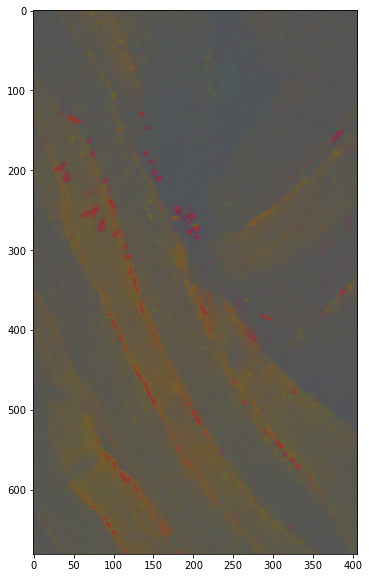

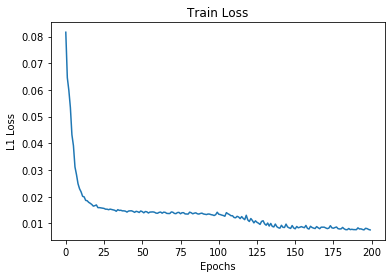

100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


In [14]:
n_epochs = 200
L1_loss = []
z_imgs = []

for epoch in tqdm(range(1, n_epochs+1)):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images in img_stack:
        images = images[None, :]
        image_x_p = torch.permute(images, (0, 3, 1, 2))
        image_x_p = image_x_p.to(device)
        optimizer.zero_grad()         
        #outputs = model(image_x_p)
        z = model.forward_enc(image_x_p)
        outputs = model.forward_dec(z)
        
        # reconstruction loss
        loss_recon = criterion(outputs, image_x_p)
        
        # variance-ordering loss
        msq0 = meansq(z[:,0,:,:])
        msq1 = meansq(z[:,1,:,:])
        msq2 = meansq(z[:,2,:,:])
        loss_varianceOrdering = f.relu(msq1-msq0) + f.relu(msq2-msq1)
        
        # total loss
        loss = loss_recon + loss_varianceOrdering
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image_x_p.size(0)
          
    train_loss = train_loss/len(img_stack)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    L1_loss.append(train_loss)
    
    if epoch%50 == 0:
        # visualize latent space
        temp_img = visualize_z(3)
        z_imgs.append(temp_img)
        # plot loss curve
        plt.plot(L1_loss)
        plt.title('Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('L1 Loss')
        plt.show()

# Analyze latent space images

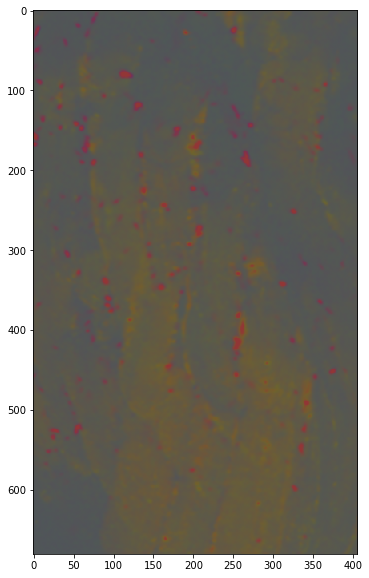

array([[238.91983, 230.38858, 217.69135],
       [240.46083, 228.60701, 217.93214],
       [240.7147 , 229.66235, 216.62296],
       ...,
       [232.77411, 234.58626, 219.63962],
       [234.0291 , 231.57214, 221.39847],
       [232.93515, 234.73259, 219.33215]], dtype=float32)

In [32]:
img = visualize_z(2)
imgsum = sum(img,2)
imgsum

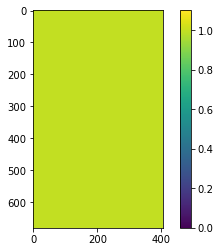

In [51]:
# test
images = img_stack[1]
images = images[None, :]
image_x_p = torch.permute(images, (0, 3, 1, 2))
image_x_p = image_x_p.to(device)
optimizer.zero_grad()         
#outputs = model(image_x_p)
z = model.forward_enc(image_x_p)

z.shape

zsum = torch.sum(z,1)

plt.imshow( zsum.detach().cpu().numpy().squeeze(),vmin=0., vmax=1.1 )
plt.colorbar()
plt.show()



In [26]:
img_stack[1]

tensor([[[ 9.3201e-03,  1.5979e-02,  1.0860e-02,  ...,  1.2023e-03,
          -1.1927e-02,  4.7328e-04],
         [ 6.9301e-03,  1.1901e-02,  7.1274e-03,  ...,  5.5700e-03,
          -9.7670e-03,  3.4160e-03],
         [ 3.7467e-03,  8.1204e-03,  1.3716e-02,  ...,  5.6694e-03,
          -2.5224e-03,  1.6174e-03],
         ...,
         [ 9.2323e-04,  5.1352e-02,  6.9349e-02,  ...,  4.5247e-02,
           3.3827e-02,  2.0773e-02],
         [ 1.0497e-02,  5.2857e-02,  6.7425e-02,  ...,  4.3076e-02,
           4.2239e-02,  2.4767e-02],
         [ 7.9035e-03,  6.1996e-02,  6.6521e-02,  ...,  4.0352e-02,
           3.8618e-02,  1.9000e-02]],

        [[ 5.9691e-03,  1.3551e-02,  1.0695e-02,  ..., -2.5196e-03,
          -4.0417e-03,  1.0264e-04],
         [ 1.0571e-02,  1.4248e-02,  1.2113e-02,  ...,  1.2439e-02,
          -9.5483e-03,  4.5957e-03],
         [ 1.4877e-02,  5.4159e-03,  1.7780e-02,  ...,  1.9610e-02,
          -5.7645e-03,  2.8374e-03],
         ...,
         [ 1.4204e-03,  5

In [15]:
z_imgs = np.asarray(z_imgs)
print(z_imgs.shape)

(4, 681, 406, 3)


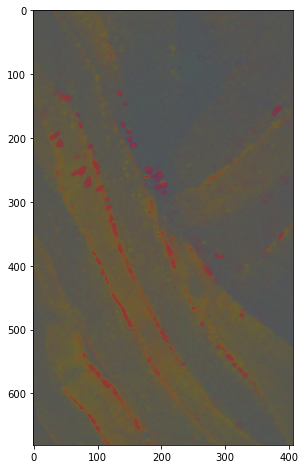

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(z_imgs[2,:,:,:])
plt.show()

In [ ]:
# iterate through the latent space image stack and save the images
n_count = 0
for img in z_imgs:
    io.imsave('img' + str(n_count) + '.png', img)
    n_count = n_count + 1

In [ ]:
# use the saved latent space images to create a movie
image_folder = '/home/arya1080/python_projects/CNN_TAM'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()